<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_FINAL_TSLA_LSTM_SENTIMENT_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 8.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=368752777389c8ca0e76f4d7c9f2d38bdc5347fd87c20b9a0412aba4cee3dbd4
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
pip install statsmodels

In [ ]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=a51aacab481289a98ea445307d6d2998811913c6e0c97b9eebf9f3d53d251373
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [ ]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from keras import regularizers


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns 

import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "TSLA",start=start,end=end,interval = "1d")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.head()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Next_close
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,88.601997
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,90.307999
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,93.811996
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,98.428001
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,96.267998


Text(0, 0.5, 'Cost (USD)')

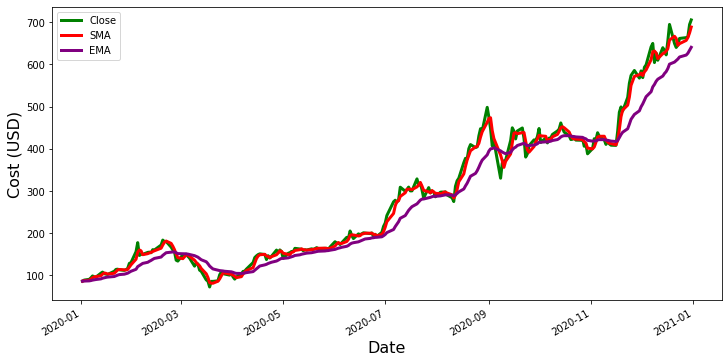

In [ ]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

# Plot price changes for the year
# Colors for the line plot
colors = ['green', 'red', 'purple']
df_plt = df[['Close', 'SMA', 'EMA', 'Date']]

# line plot
df_plt.plot(color=colors, x = 'Date', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# title and labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cost (USD)', fontsize=16)

In [ ]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Date')


In [ ]:
# Import sentiment data and merge
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
sent = pd.read_csv('TSLA_sentiment_submissions.csv')
sent = sent.rename(columns={'date':'Date'})
sent['Date'] = pd.to_datetime(sent['Date'])
df = pd.merge(df, sent, on = 'Date', how='left')
#df = df.fillna(0)
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,Unnamed: 0,compound,Count,average
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02,252.000000,253.000000,253.000000,2.530000e+02,252.000000,252.000000,252.000000,252.000000
mean,289.108428,297.288411,280.697937,289.997067,289.997067,7.530795e+07,290.806373,287.564012,270.266095,1.911766e+09,182.488095,5.037606,32.817460,0.144562
std,167.665389,171.702889,163.350196,168.995613,168.995613,4.013706e+07,168.839956,167.122237,154.357671,8.882851e+08,104.630006,7.139996,36.248567,0.197860
min,74.940002,80.972000,70.101997,72.244003,72.244003,1.735770e+07,72.244003,81.092667,86.052002,0.000000e+00,1.000000,-4.830000,1.000000,-0.760100
25%,148.367996,154.990005,143.222000,149.792007,149.792007,4.713450e+07,149.872997,149.241999,139.893243,1.329942e+09,91.750000,0.771500,11.000000,0.065281
50%,244.296005,245.600006,237.119995,241.731995,241.731995,7.025550e+07,257.453995,227.206665,201.239920,1.786169e+09,183.000000,2.943150,20.000000,0.149701
75%,421.390015,430.500000,410.579987,421.200012,421.200012,9.454550e+07,421.215012,421.653330,415.487761,2.803595e+09,272.250000,7.135425,39.000000,0.239371
max,699.989990,718.719971,691.119995,705.669983,705.669983,3.046940e+08,705.669983,688.813334,640.711540,3.571193e+09,363.000000,46.235000,272.000000,0.980200


In [ ]:
# Check for correlation between sentiment and price change
df['per_change'] = ((df['Next_close'] - df['Close'])/df['Next_close'])*100
df.corr()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,Unnamed: 0,compound,Count,average,per_change
Open,1.000000,0.998722,0.998407,0.997204,0.997204,-0.365506,0.993037,0.998032,0.987991,0.949966,0.938420,0.353780,0.287818,0.226523,-0.027249
High,0.998722,1.000000,0.998116,0.998931,0.998931,-0.347166,0.994442,0.998201,0.987203,0.949572,0.936857,0.368476,0.304465,0.227754,-0.029793
Low,0.998407,0.998116,1.000000,0.998407,0.998407,-0.383821,0.995062,0.997682,0.988438,0.951300,0.939752,0.348913,0.274825,0.230989,-0.019037
Close,0.997204,0.998931,0.998407,1.000000,1.000000,-0.360490,0.995523,0.997655,0.986844,0.949292,0.936582,0.363087,0.292673,0.230472,-0.027493
Adj Close,0.997204,0.998931,0.998407,1.000000,1.000000,-0.360490,0.995523,0.997655,0.986844,0.949292,0.936582,0.363087,0.292673,0.230472,-0.027493
Volume,-0.365506,-0.347166,-0.383821,-0.360490,-0.360490,1.000000,-0.370728,-0.371831,-0.409523,-0.420621,-0.492280,0.239520,0.493474,-0.119839,-0.125142
Next_close,0.993037,0.994442,0.995062,0.995523,0.995523,-0.370728,1.000000,0.993467,0.983348,0.944457,0.936461,0.359752,0.286989,0.227319,0.052469
SMA,0.998032,0.998201,0.997682,0.997655,0.997655,-0.371831,0.993467,1.000000,0.990876,0.949680,0.938302,0.349708,0.284272,0.226620,-0.026842
EMA,0.987991,0.987203,0.988438,0.986844,0.986844,-0.409523,0.983348,0.990876,1.000000,0.953448,0.949993,0.292217,0.222146,0.225179,-0.022396
obv,0.949966,0.949572,0.951300,0.949292,0.949292,-0.420621,0.944457,0.949680,0.953448,1.000000,0.963856,0.277611,0.212706,0.201260,-0.048705


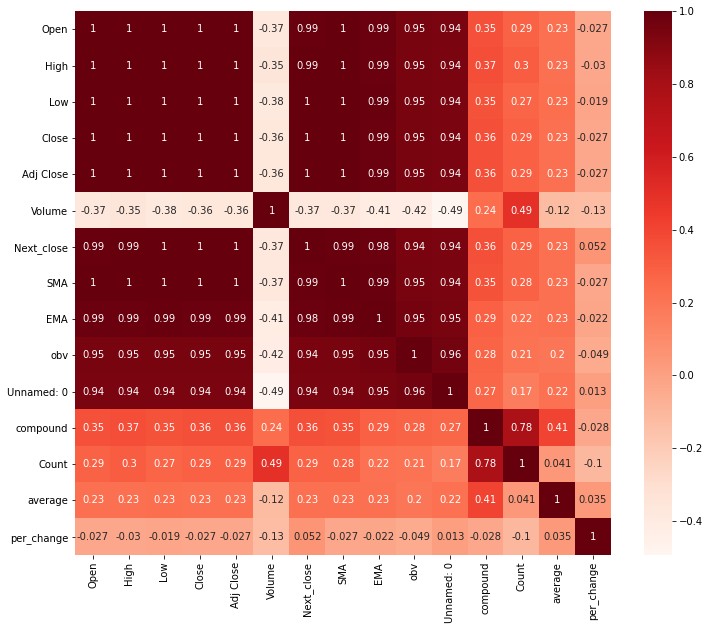

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df = df[['Next_close','Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

In [ ]:
# Scale data with MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()

# Data Loader Parameters
BATCH_SIZE = 2       # Factors of 202 (train size):   1, 2, 101
BUFFER_SIZE = 20
TRAIN_SPLIT = round(len(df)*0.8)  # 80-20 train-test split 
print(TRAIN_SPLIT) # Batches should be factor of train size

# LSTM Parameters
EVALUATION_INTERVAL = 20   
EPOCHS = 500 # Early stopping implemented, so this can be artbitrarily high and still work
PATIENCE = 10  # number of epochs to wait before early stop if no progress on the validation set. # Tested this out with other values 3 and 5

202


**Scaling the Data**

The values in our datset are of different scales which can increase the difficulty of the problem being modeled. The volume of traders per day is much higher than the value for the previous day's high, open, etc. This high value mayresult in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error. For this reason we scale our data before proceeding

MinMaxScaler() subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. This scaling method preserves the shape of the original distribution. It doesn't meaningfully change the information embedded in the original data. Note that MinMaxScaler doesn't reduce the importance of outliers. The default range for the feature returned by MinMaxScaler is 0 to 1


In [ ]:
# Scaled data with MinMaxScaler
 # from pandas df to array of values
data = df.values
# define min max scaler
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(data)

In [ ]:
# Split into endogenous and exogenous 
X = dataset[:,1:]
y = dataset[:, 0]


# LSTM Model

In [ ]:
# This was taken from the book Deep Learning with Python by François Chollet 

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 20    # How far back the model looks
future_target = 1 # this analysis is concerned with 1 step (hour/day) into the future
STEP = 1    

x_train_model, y_train_model = multivariate_data(X,y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_model, y_val_model = multivariate_data(X,y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

In [ ]:
print ('Window of past history : {}'.format(x_train_model[0].shape))


(182, 20, 9)
Window of past history : (20, 9)
(20, 9)


In [ ]:
train_data_model = tf.data.Dataset.from_tensor_slices((x_train_model, y_train_model))
train_data_model = train_data_model.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() 
val_data_model = tf.data.Dataset.from_tensor_slices((x_val_model, y_val_model))
val_data_model = val_data_model.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  ##Shuffle with buffer

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with input shape of x_train_model.shape[-2:]
model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?

model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #adam said to be best in CV


In [ ]:
# Grid Search
# This build classifier and KerasClassifer step is taken from https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/. It is a wrapped which allows the use of Sklearn CV with Keras

def build_classifier(optimizer, dropout_rate):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                 kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                 input_shape=x_train_model.shape[-2:]))    # LSTM layer with input shape of x_train_model.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #
  return model

grid_model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [ 1, 2, 101],
              'optimizer' : ['adam','RMSprop'],
              'dropout_rate' : [0.0, 0.1, 0.2],  #What is 'forgotten' - important to avoid overfitting
}

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 2)

In [ ]:
#GridSearchCV
grid_search = grid_search.fit(x_train_model, y_train_model)

91/91 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


91/91 [==============================] - 2s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 3s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 9ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 3s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 9ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 3s 9ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 2s 8ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


182/182 [==============================] - 3s 4ms/step - loss: nan - mean_absolute_error: nan - mape: nan


In [ ]:
print("Best accuracy: {}\nBest combination: {}".format(-grid_search.best_score_, 
                             grid_search.best_params_))

Best accuracy: 0.10690680697012497
Best combination: {'batch_size': 1, 'dropout_rate': 0.0, 'optimizer': 'adam'}


In [ ]:
BREAK TO UPDATE

SyntaxError: ignored

In [ ]:
BATCH_SIZE = 1
DROPOUT_RATE = 0
OPTIMIZER = 'adam'

train_data_model = tf.data.Dataset.from_tensor_slices((x_train_model, y_train_model))
train_data_model = train_data_model.cache().batch(BATCH_SIZE).repeat()
val_data_model = tf.data.Dataset.from_tensor_slices((x_val_model, y_val_model))
val_data_model = val_data_model.cache().batch(BATCH_SIZE).repeat()  

In [ ]:
# Model updated with parameters as determined using Grid Search
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 4, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_model.shape[-2:]
model.add(tf.keras.layers.Dropout(DROPOUT_RATE))   # Add dropout rate
model.add(tf.keras.layers.Dense(1)) 
model.compile(optimizer='RMSprop', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #


In [ ]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

# Train with early stopping so as to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True) 
history = model.fit(train_data_model,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_model,
                                            callbacks=[early_stopping],
                                            validation_steps=17)   

Evaluation Threshold: 20
Epochs: 500
Epoch 1/500
20/20 [==============================] - 3s 32ms/step - loss: 0.0513 - mean_absolute_error: 0.1977 - mape: 145.5898 - val_loss: 0.0328 - val_mean_absolute_error: 0.1487 - val_mape: 106.1244
Epoch 2/500
20/20 [==============================] - 0s 7ms/step - loss: 0.0134 - mean_absolute_error: 0.0416 - mape: 899713.3750 - val_loss: 0.0256 - val_mean_absolute_error: 0.1249 - val_mape: 88.8146
Epoch 3/500
20/20 [==============================] - 0s 8ms/step - loss: 0.0116 - mean_absolute_error: 0.0434 - mape: 43.2919 - val_loss: 0.0131 - val_mean_absolute_error: 0.0621 - val_mape: 43.1304
Epoch 4/500
20/20 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_absolute_error: 0.0324 - mape: 23.6648 - val_loss: 0.0085 - val_mean_absolute_error: 0.0170 - val_mape: 11.8116
Epoch 5/500
20/20 [==============================] - 0s 10ms/step - loss: nan - mean_absolute_error: nan - mape: nan - val_loss: nan - val_mean_absolute_error: 

In [ ]:
# Plot training 

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

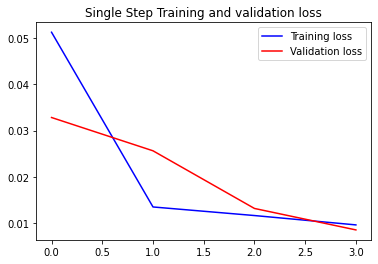

In [ ]:
plot_train_history(history,
                   'Single Step Training and validation loss')

In [ ]:
# Plot 3 examples of predictions for different timeframes
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

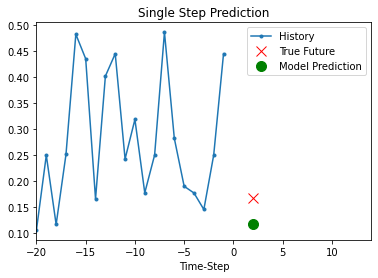

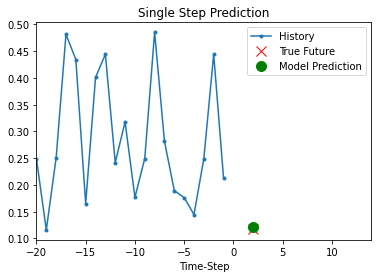

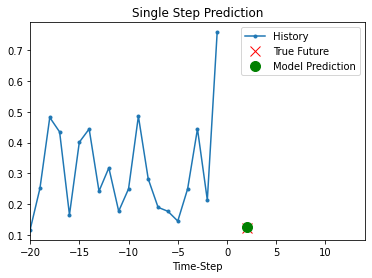

In [ ]:
for x, y in val_data_model.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 2,
                   'Single Step Prediction')
    plot.show()

## Cross Validation

In [ ]:
# Blocking Cross Validation
n_splits = 10
X = dataset[:,1:]
y= dataset[:,0]

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# Keras Wrapper
from keras.wrappers.scikit_learn import KerasClassifier
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting - is this correct?
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_model.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) 
  return model


In [ ]:
model = KerasClassifier(build_fn=create_model)
btscv = BlockingTimeSeriesSplit(n_splits=10)    # Or should I use TimeSeriesSplit?
mse_block= -cross_val_score(model, x_train_model, y_train_model, cv=btscv, scoring='neg_mean_squared_error')
mae_block = -cross_val_score(model, x_train_model, y_train_model, cv=btscv, scoring='neg_mean_absolute_error')

1/1 [==============================] - 2s 2s/step - loss: 18.8853 - mean_absolute_error: 3.5464 - mape: 61493284.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 24.3955 - mean_absolute_error: 4.2206 - mape: 37187732.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 22.0501 - mean_absolute_error: 3.9446 - mape: 9792342.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 21.2859 - mean_absolute_error: 3.8393 - mape: 25033.0664


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 23.8460 - mean_absolute_error: 4.1471 - mape: 22201976.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 20.3989 - mean_absolute_error: 3.7568 - mape: 26663394.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 19.1049 - mean_absolute_error: 3.7224 - mape: 69720328.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 20.9935 - mean_absolute_error: 3.8791 - mape: 37069796.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 15.6941 - mean_absolute_error: 3.2701 - mape: 169817168.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 20.7644 - mean_absolute_error: 3.7735 - mape: 18367496.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 24.3324 - mean_absolute_error: 4.1837 - mape: 15798270.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 22.2792 - mean_absolute_error: 3.9665 - mape: 5438026.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 24.7050 - mean_absolute_error: 4.2289 - mape: 36551328.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 24.8824 - mean_absolute_error: 4.2574 - mape: 20975146.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 23.4034 - mean_absolute_error: 4.1004 - mape: 14243486.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 22.2496 - mean_absolute_error: 3.9560 - mape: 5988615.5000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 28.9265 - mean_absolute_error: 4.7476 - mape: 102422944.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 26.4167 - mean_absolute_error: 4.5003 - mape: 62156168.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print('The mean squared errors for each of the 10 splits are:', mse_block)
print('The mean mse for the folds is: ', (sum(mse_block)/10))

print('The mean absolute errors for each of the 10 splits are:', mae_block)
print('The mean mae for the folds is: ', (sum(mae_block)/10))

The mean squared errors for each of the 10 splits are: [0.00140726 0.00138567 0.00571516 0.00091956 0.00160545 0.00798307
 0.00122918 0.03676864 0.02307249 0.00287458]
The mean mse for the folds is:  0.00829610606931026
The mean absolute errors for each of the 10 splits are: [0.03396836 0.0325612  0.07207578 0.02990895 0.03679636 0.07272515
 0.03130527 0.20042753 0.14586113 0.08152139]
The mean mae for the folds is:  0.07371511208437241


In [ ]:
df_results = pd.DataFrame(mse_block)
df_results['RMSE'] = np.sqrt(df_results[0])
df_results = df_results.rename(columns={0:'TSLA_MSE', 'RMSE':'TSLA_RMSE'})
df_results

,TSLA_MSE,TSLA_RMSE
0,0.001407,0.037513
1,0.001386,0.037225
2,0.005715,0.075599
3,0.000920,0.030324
4,0.001605,0.040068
5,0.007983,0.089348
6,0.001229,0.035060
7,0.036769,0.191752
8,0.023072,0.151896
9,0.002875,0.053615


In [ ]:
df_results.to_csv('TSLA_SENTIMENT_LSTM_HR.csv')


In [ ]:
df_results.describe()

,TSLA_MSE,TSLA_RMSE
count,10.000000,10.000000
mean,0.008296,0.074240
std,0.012062,0.055623
min,0.000920,0.030324
25%,0.001391,0.037297
50%,0.002240,0.046842
75%,0.007416,0.085911
max,0.036769,0.191752
